
# OLS

[Download notebook :fontawesome-solid-download:](../ols.ipynb){: .md-button .md-button--primary download="ols.ipynb"}

Very simple notebook to get started with python, simulating and estimating. In this homework, we hope to learn

- setup an python environment, see [getting started](http://econ21340.lamadon.com/getting-started/).
- familiarize ourselves with basic [numpy](https://numpy.org/)
- familiarize ourselves with [keras](https://keras.io/)

We consider the simple linear model 

$$ y_i = \beta x_i + \epsilon_i $$

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
import numpy as np

# the following loads my solution file, which you do not have! 
# you should comment the following line, or create your solution in solutions/sol_ols.py
# from solutions.sol_ols import *


/Users/connorjones/mystuff/uchicago-31340-psets


## Simulate data
We start by simulating data of N observations and K regressors. We keep everything normal to keep things simple.

In [2]:
N = 1000
K = 10
X = np.random.normal(size = (N,K))
E = np.random.normal(size = N)
beta = np.linspace(0,1,num=K)

Y = np.matmul(X,beta) + E

As you can see we make extensive use of vector operations from the [numpy](https://numpy.org/) package.

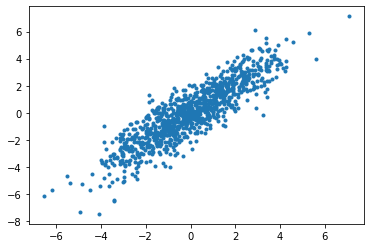

In [3]:
import matplotlib.pyplot as plt
plt.plot(np.matmul(X,beta),Y,'.')
plt.show()

## Solve using numpy and linear algebra

!!! question
    This is the first question. Write your own `numpy_ols` function, which takes as an input `(Y,X)` and returns the OLS estimates. You only need to use two numpy functions `np.transpose`, `np.matmul` and `np.linalg.solve`. The function should just a few lines.
    
We use the created function (in this document it is using the one that I wrote) and we then plot the estimated $\beta$ versus the true $\beta$.    

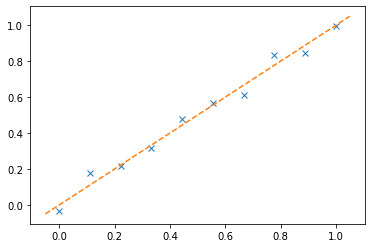

In [4]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def numpy_ols(Y, X):
    inside = np.matmul(np.transpose(X), X)
    alpha = np.linalg.solve(inside, np.identity(K))
    inv_trn = np.matmul(alpha, np.transpose(X))
    r = np.matmul(inv_trn, Y)
    return r;

beta_hat = numpy_ols(Y,X)
plt.plot(beta,beta_hat,'x')
abline(1,0)
plt.show()

## Solve using Keras

Now we are going to make an overkill, which is to use [Keras](https://keras.io/) to solve this linear problem. Kera allows to build models by composing layers. For instance, here, imagine I wanted to fit a neural net on the data I have generated, I would do the following:

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [6]:
model = Sequential()
model.add(Dense(1, input_shape=(K,)))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


2021-10-21 20:57:08.205527: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-21 20:57:08.206027: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


The first layer is a [Dense layer](https://keras.io/layers/core/), and it implements the following transformation:
$$ l_i = \sum_{k=1}^K w_k Z_{ik} $$
for a set of weights $w_k$ that we want to estimate and some input $Z_{ik}$. Later on we will feed `bacthes` from X to this.

Because we are using a `sequential` construction, the second layer takes the output $l_i$ of the first layer and generate an output
$$ \hat{y}_i = g(l_i) $$
for some non linear function refered to as activation functions. 

See this [description of activation functions](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html) including the [one we have specificed](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#sigmoid).

The next command initializes the model, specifies the optimzer to use and specifies the loss function to minimize. Here we will try to minimize the square loss between provided output and model output:

$$ \min_{w_k} \sum_i (\hat{y}_i - y_i)^2 $$

In [7]:
model.compile(optimizer='adam', loss='mse')

It is finally time to feed the data to our model. We specify the input $X$, the output $Y$, the number of passes we want to do on the data `epochs` as well as the size of the batches, meaning the numbers of $i$ observation to give at the same time to compute one update step of the optimizer.

In [8]:
hist = model.fit(X, Y, epochs=100, batch_size=50, verbose=0)

We then extract the estimated weights $w_k$ and compare them to the $\beta$ that generated the data.

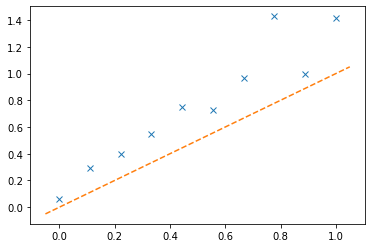

In [9]:
beta_keras = model.layers[0].get_weights()[0]
plt.plot(beta,beta_keras[0:K],'x')
abline(1,0)
plt.show()

!!! question 
    Question 2: Clearly the neural net that we used doesn't deliver the right estimates for $\beta$. The functional form that we specified when creating the model ressembles more a `logit` than a linear model. Given what you know about the shape of the Dense layer and the Sigmoid activation, modify the model in order to have a functional form identical to the linear form. Either replace the `model2 = kera_linear(K)` int he following code or write you own to try to get a good fit.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


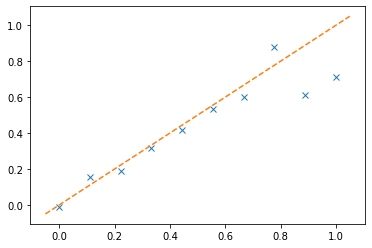

In [10]:
model2 = Sequential()
model2.add(Dense(1, input_shape=(K,)))
model2.add(Activation('linear'))
model2.summary()

model2.compile(optimizer='adam', loss='mse')
hist2 = model2.fit(X, Y, epochs=100, batch_size=50, verbose=0);
beta_keras = model2.layers[0].get_weights()[0]
plt.plot(beta,beta_keras[0:K],'x')
abline(1,0)

##### Fitting non-linear functions

Let's step it up! Let's try to fit a non linear function of one variable. We are going to use the `cos` function.

In [11]:
X = 10*np.random.uniform(size = N)
Y = np.cos(X) + 0.5*np.random.normal(size = N)

As we can see, this is a function which is neither linear or a simple activation function:

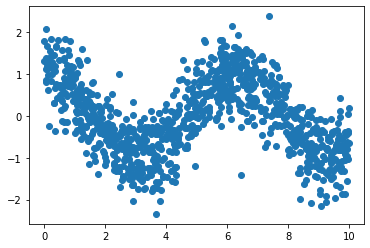

In [12]:
plt.plot(X,Y,'o')
plt.show()

This is where multilayers shine! We create the following model:

In [13]:
model3 = Sequential()
model3.add(Dense(20, input_shape=(1,)))
model3.add(Activation('elu'))
model3.add(Dense(1))
model3.add(Activation('elu'))
model3.add(Dense(1))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                40        
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


!!! question
    Explain in your own words the structure of this neural net! How many input, what are each layers. Next write your own `fit_model3` function which takes X and Y and model3 and fits it. You needs to adapt the few line of codes that we have used in previous sections. You will also need to play a bit with batch sizes and epochs to succeed in achieving a good fit, as in the following figure.

In [17]:
def fit_model3(model,X,Y):
    model.compile(optimizer='adam', loss='mse')
    hist3 = model.fit(X, Y, epochs=500, batch_size=75, verbose=0);
    beta_keras = model.layers[2].get_weights()[0]
    return;

fit_model3(model3,X,Y)


We then construct the predition from the model and plot it on top of the data! Voila!

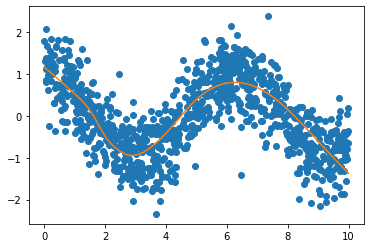

In [18]:
Xp = np.linspace(0,10,num=50)
Yp = model3.predict(Xp)
plt.plot(X,Y,'o')
plt.plot(Xp,Yp,'-')
plt.show()